In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
zip_train = zipfile.ZipFile('/content/drive/MyDrive/Oral Cancer.zip', 'r') #Opens the zip file in read mode
zip_train.extractall('/tmp') #Extracts the files into the /tmp folder
zip_train.close()

In [ ]:
pip install -U tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install visualkeras
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# General parameters
epochs = 20
image_size = 240
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
folder_path = ("/tmp/Oral Cancer")

In [ ]:
import os
import cv2
import numpy as np

def load_and_process_dataset(folder_path):
    """Loads and processes images using alternative while loop structures."""

    dataset = []
    labels = []
    class_folders = ['Normal', 'Squamous Cell Carcinoma']

    class_index = 0
    while class_index < len(class_folders):
        class_folder = class_folders[class_index]
        images_path = os.path.join(folder_path, class_folder)

        image_index = 0
        while True:  # Loop infinitely until a "break" occurs
            try:
                image_name = os.listdir(images_path)[image_index]  # Access by index
                image_path = os.path.join(images_path, image_name)

                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image = cv2.resize(image, (240, 240))

                dataset.append(image)
                labels.append(class_index)  # Use class_index directly for labels

                image_index += 1
            except IndexError:  # Handle end of image list
                break  # Exit the inner loop

        class_index += 1

    return np.array(dataset), np.array(labels)

# Assuming `folder_path` is already a string
dataset, labels = load_and_process_dataset(folder_path)

# Convert to NumPy arrays
dataset = np.array(dataset)
lab = np.array(labels)

# Print shapes
print(dataset.shape, labels.shape)

(10002, 240, 240, 3) (10002,)


In [ ]:
print(np.array(dataset).shape, np.array(labels).shape)
# Convert to NumPy arrays and print shapes in a single line

(10002, 240, 240, 3) (10002,)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.array(dataset), np.array(labels), test_size=0.2, shuffle=True, random_state=42)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# Input layer
input_layer = Input(shape=(image_size, image_size, 3))

# Convolutional layers
conv1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same")(input_layer)
conv1 = BatchNormalization()(conv1)
maxpool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same")(maxpool1)
conv2 = BatchNormalization()(conv2)
maxpool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same")(maxpool2)
conv3 = BatchNormalization()(conv3)
maxpool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same")(maxpool2)
conv4 = BatchNormalization()(conv4)
maxpool4 = MaxPooling2D((2, 2))(conv4)

conv5 = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same")(maxpool2)
conv5 = BatchNormalization()(conv5)
maxpool5 = MaxPooling2D((2, 2))(conv5)

conv6 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same")(maxpool2)
conv6 = BatchNormalization()(conv6)
maxpool6 = MaxPooling2D((2, 2))(conv6)

conv7 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same")(maxpool2)
conv7 = BatchNormalization()(conv7)
maxpool7 = MaxPooling2D((2, 2))(conv7)

# Flatten layer
flatten = Flatten()(maxpool7)

# Dense layers with regularization and dropout
dense1 = Dense(units=256, activation='relu',
               kernel_regularizer=regularizers.L2(1e-4))(flatten)
dropout1 = Dropout(0.5)(dense1)

dense2 = Dense(units=128, activation='relu',
               kernel_regularizer=regularizers.L2(1e-4))(dropout1)
dropout2 = Dropout(0.5)(dense2)


dense3 = Dense(units=64, activation='relu',
               kernel_regularizer=regularizers.L2(1e-4))(dropout1)
dropout3 = Dropout(0.5)(dense3)


output_layer = Dense(units=1, activation='sigmoid')(dropout3)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Compile the model
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 240, 240, 32)      896       
                                                                 
 batch_normalization_16 (Ba  (None, 240, 240, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 120, 120, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 120, 120, 64)      18496     
                                                                 
 batch_normalization_17 (Ba  (None, 120, 120, 64)      256 

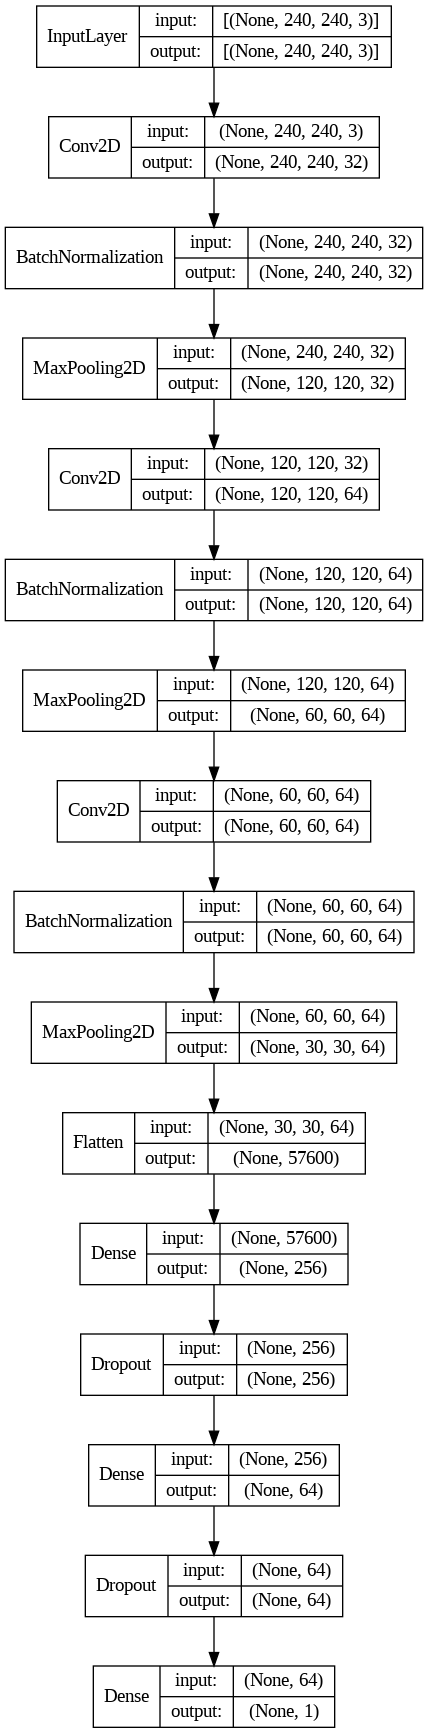

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)


In [ ]:
class_weights = {}
for cls in np.unique(y_train):
    count = np.sum(y_train == cls)
    class_weights[cls] = 1.0 / count
print("Class Weights:")
for cls, weight in class_weights.items():
    print(f"Class {cls}: Weight {weight}")

Class Weights:
Class 0: Weight 0.000250501002004008
Class 1: Weight 0.0002494387627837366


In [ ]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'model', 'x_train', 'y_train', 'x_test', and 'y_test' are already defined

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Compile the model
model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=30,
    class_weight=class_weights_dict,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/30
251/251 [==============================] - 9s 23ms/step - loss: 0.2659 - accuracy: 0.9736 - val_loss: 0.9024 - val_accuracy: 0.8661
Epoch 2/30
251/251 [==============================] - 5s 21ms/step - loss: 0.2038 - accuracy: 0.9868 - val_loss: 0.8996 - val_accuracy: 0.8191
Epoch 3/30
251/251 [==============================] - 5s 21ms/step - loss: 0.2237 - accuracy: 0.9831 - val_loss: 1.5328 - val_accuracy: 0.8186
Epoch 4/30
251/251 [==============================] - 5s 21ms/step - loss: 0.2315 - accuracy: 0.9829 - val_loss: 0.7918 - val_accuracy: 0.8246
Epoch 5/30
251/251 [==============================] - 5s 21ms/step - loss: 0.2371 - accuracy: 0.9835 - val_loss: 1.3785 - val_accuracy: 0.8046
Epoch 6/30
251/251 [==============================] - 5s 21ms/step - loss: 0.2326 - accuracy: 0.9863 - val_loss: 1.0161 - val_accuracy: 0.6952
Epoch 7/30
251/251 [==============================] - 5s 21ms/step - loss: 0.2395 - accuracy: 0.9854 - val_loss: 0.8467 - val_accuracy: 0.8616

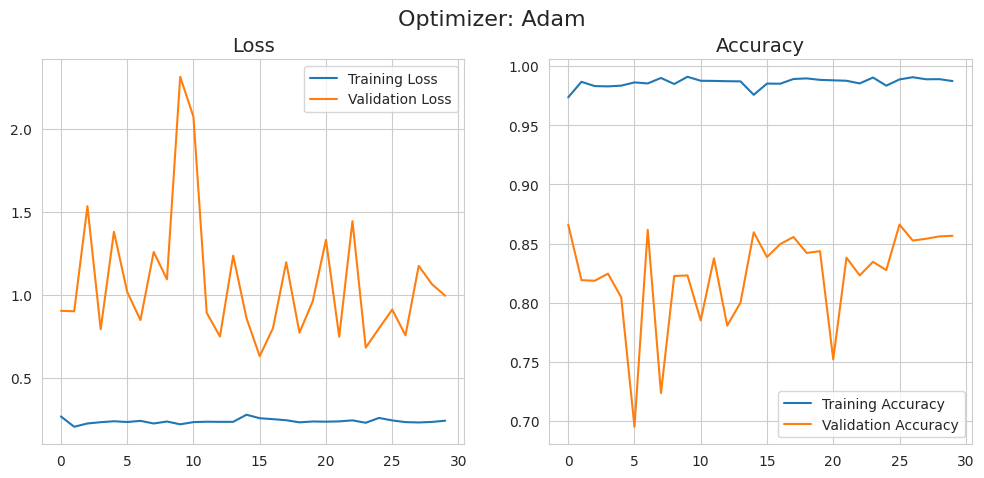

In [ ]:
import seaborn as sns

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss', fontsize=14)
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy', fontsize=14)
ax2.legend()

fig.suptitle('Optimizer: Adam', fontsize=16)
plt.show()

In [ ]:
# Assuming 'model', 'x_test', and 'y_test' are already defined

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Print the accuracy
print('The accuracy of the baseline model CNN is {:.2f}%!'.format(test_accuracy * 100))

63/63 [==============================] - 0s 7ms/step - loss: 0.9933 - accuracy: 0.8566
The accuracy of the baseline model CNN is 85.66%!
